In [7]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def shrinkage_cov_matrix(X, T):
    p, n = X.shape # Get shape of matrix
    
    x_mean = np.sum(X, axis=1)/n # Find mean of each row
    x_mean_M = np.tile(x_mean, (n, 1)).T # Repeat mean values as columns in a p x n matrix
    Y = X - x_mean_M
    
    W = []
    # Generate W array (which is 3D) of size (n, p, p), order of indices (k, i, j)
    for k in range(n):
        w = Y[:,k]
        W.append(np.outer(w, w))
    W_mean = np.sum(W, axis=0)/n
    
    # Emperically estimated covariance matrix
    S = n / (n-1) * W_mean
    
    W_mean_rep = np.tile(W_mean, (n, 1, 1))
    V = W - W_mean_rep
    # Compute variance of elements of the covariance matrix
    Var = n / (n-1)**3 * np.sum(V**2, axis=0)
    
    # Compute estimated shrinkage intensity parameter lambda
    lmbda_est = np.sum(Var) / np.sum((T-S)**2)
    
    # Compute shrinkage covariance matrix
    C_shrinkage = lmbda_est*T + (1-lmbda_est)*S
    
    return C_shrinkage, S, lmbda_est

In [9]:
def Q_func(s, X):
    Nd, Ns = X.shape
    #assert s >= 2 and s <= (Ns-2) and math.floor(s) == s
    assert s >= 2 and s <= (Ns-2) and np.floor(s) == s
    col_combos = list(it.combinations(range(Ns), s)) # Tuples of possible combinations of s out of Ns column indices

    Z_sum = np.zeros((Nd, Nd))
    S2_sum = np.zeros((Nd, Nd))

    for col_combo in col_combos:
        X1 = X[:, col_combo]
        X2 = X[:, np.delete(range(Ns), col_combo)]
        
        S1 = 1/(s-1)*np.matmul(X1, X1.T)
        S2 = 1/(Ns-s-1)*np.matmul(X2, X2.T)
        S2_sum += S2
        
        # Diagonalize S_i = U_i * D_i * U_i^T
        evals1, U1 = np.linalg.eigh(S1)
        D1 = np.diag(evals1)
        #evals2, U2 = np.linalg.eig(S2)
        #D2 = np.diag(evals2)
        
        # Verify that the matrix diagonalization is correct (up to absolute error of 1e^-10)
        S1_trial = np.matmul(np.matmul(U1, D1), U1.T)
        #S2_trial = np.matmul(np.matmul(U2, D2), U2.T)
        assert np.allclose(S1, S1_trial, 0, 1e-10)
        #assert np.allclose(S2, S2_trial, 0, 1e-10)
        
        # Compute estimator Z = U_1 * diag(U_1^T * S_2 * U_1) * U_1^T
        Z = np.matmul(np.matmul(U1, np.diag(np.diag(np.matmul(np.matmul(U1.T, S2), U1)))), U1.T)
        Z_sum += Z
    
    Z_avg = Z_sum / len(col_combos)
    S2_avg = S2_sum / len(col_combos)
    M = Z_avg - S2_avg
    Q_val = np.trace(np.matmul(M, M.T)) # Frobenius matrix norm
    
    return Q_val, Z_avg

In [10]:
def NERCOME(X):
    Nd, Ns = X.shape
    
    # NERCOME requires the data vectors to be mean subtracted
    x_mean = np.sum(X, axis=1)/n # Find mean of each row
    x_mean_M = np.tile(x_mean, (n, 1)).T # Repeat mean values as columns in a p x n matrix
    Y = X - x_mean_M
    
    s = np.arange(Ns-3)+2
    Q = []
    for i in s:
        Q.append(Q_func(i, Y)[0])
    
    s_min = s[np.array(Q).argmin()]
    
    Z = Q_func(s_min, Y)[1]
    S = 1/(Ns-1)*np.matmul(Y, Y.T)
    
    return Z, S, s_min

In [15]:
p = 18
n = 20
mean = 0
sigmaA = 1.1
sigmaB = 1.1

A = np.random.normal(mean, sigmaA, size=(p//2, n))
B = np.random.normal(mean, sigmaB, size=(p-p//2, n))
X = np.vstack((A, B))

T = np.identity(p) # Target matrix
C_true = sigmaA**2 * np.identity(p) # True covariance CHANGE THIS!!

C_shrinkage, S1, lmbda_est = shrinkage_cov_matrix(X, T)
C_nercome, S2, s_min = NERCOME(X)

# We require the empirically estimated covariance matrices to be (almost) identical
assert np.allclose(S1, S2, 0, 1e-10)

MSE_MC = np.trace((S1-C_true)@(S1-C_true).T)
MSE_MCS = np.trace((C_shrinkage-C_true)@(C_shrinkage-C_true).T)
MSE_NERCOME = np.trace((C_nercome-C_true)@(C_nercome-C_true).T)
#MSE_TARGET = np.trace((T-C_true)@(T-C_true).T)

print(f"MSE for MC: {MSE_MC}")
print(f"MSE for MC+S: {MSE_MCS}")
print(f"MSE for NERCOME: {MSE_NERCOME}")

MSE for MC: 26.221352876663904
MSE for MC+S: 0.79583047699819
MSE for NERCOME: 0.3620447340314529


Text(0, 0.5, 'Eigenvalues')

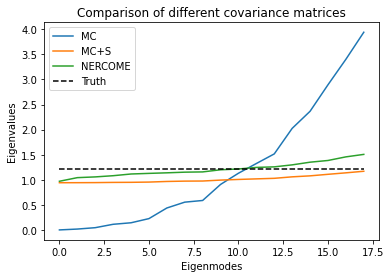

In [20]:
evals_MC = np.linalg.eigvalsh(S1)
evals_MCS = np.linalg.eigvalsh(C_shrinkage)
evals_NERCOME = np.linalg.eigvalsh(C_nercome)
evals_true = np.linalg.eigvalsh(C_true)

plt.plot(evals_MC, label="MC")
plt.plot(evals_MCS, label="MC+S")
plt.plot(evals_NERCOME, label="NERCOME")
plt.plot(evals_true, "k--", label="Truth")
plt.legend()
plt.title("Comparison of different covariance matrices")
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")